In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
from sklearn.preprocessing import OneHotEncoder


In [2]:
%matplotlib inline

In [3]:
def fetch_data(url: str) -> pd.DataFrame:
    df = pd.read_csv(url)
    return df

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df    
        
def find_string_cols(df: pd.DataFrame) -> List[str]:
    return df.select_dtypes(include='object').columns.tolist()

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = clean_columns(df)
    string_cols = find_string_cols(df)
    for col in string_cols:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    return df

def log_variables(df: pd.DataFrame, cols_to_transform: List[str]) -> pd.DataFrame:
    for col in cols_to_transform:
        df[col] = np.log1p(df[col])
    return df

def train_test_val_split(df: pd.DataFrame, val_split: float = 0.2, test_split: float = 0.2) -> pd.DataFrame:
    """
    Function to split a dataframe into train, test, and validation sets.

    
    Args:
        df (pd.DataFrame): dataframe to split
        val_split (float): percentage of data to use for validation
        test_split (float): percentage of data to use for testing

    Returns:
        pd.DataFrame: train, test, and validation sets

    """
    assert val_split + test_split < 1, "val_split + test_split must be less than 1"

    n_train = int(len(df) * (1 - val_split - test_split))
    n_val = int(len(df) * val_split)
    n_test = len(df) - n_train - n_val

    train_set = df[:n_train]
    test_set = df[n_train:(n_train + n_test)]
    val_set = df[(n_train + n_test):]

    return train_set, test_set, val_set

def impute_missing_values(df: pd.DataFrame, strategy: str) -> pd.DataFrame:
    """
    Function to impute missing values in a dataframe.

    Args:
        df (pd.DataFrame): dataframe to impute
        strategy (str): strategy to use for imputation. Must be one of 'median', 'mean', or 'zero'

    Returns:
        pd.DataFrame: dataframe with imputed values
    """

    missing_cols = df.columns[df.isnull().any()].tolist()
    
    if strategy == 'median':
        for col in missing_cols:
            df.loc[:, col] = df[col].fillna(df[col].median())
        return df

    elif strategy == 'mean':
        for col in missing_cols:
            df.loc[:, col] = df[col].fillna(df[col].mean())
        return df
    
    elif strategy == 'zero':
            for col in missing_cols:
                df.loc[:, col] = df[col].fillna(0)
            return df
    else: 
        raise ValueError("strategy must be one of 'median', 'mean', or 'zero'")

def train_linear_regression(X, y):
    """
    Function to train a linear regression model.

    Args:
        X (np.array): array of features
        y (np.array): array of target values

    Returns:
        tuple: intercept, coefficients and predicted y_vals
    """
    X = np.column_stack([np.ones([len(X), 1]), X])
    weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    y_pred = X.dot(weights)
    return weights[0], weights[1:], y_pred

def train_linear_regression_reg(X: np.array, y: np.array, reg_term: float = 0.001):
    """
    Function to train a linear regression model.

    Args:
        X (np.array): array of features
        y (np.array): array of target values

    Returns:
        tuple: intercept, coefficients and predicted y_vals
    """
    X = np.column_stack([np.ones([len(X), 1]), X])
    xtx = X.T.dot(X)
    xtx = xtx + reg_term * np.eye(xtx.shape[0])

    weights = (np.linalg.inv(xtx)).dot(X.T).dot(y)
    y_pred = X.dot(weights)
    return weights[0], weights[1:], y_pred
 


def rmse(y, y_pred):
    """
    Function to calculate root mean squared error.

    Args:
        y (np.array): array of target values
        y_pred (np.array): array of predicted values

    Returns:
        float: root mean squared error
    """
    return np.sqrt(np.mean((y - y_pred)**2))

def prepare_data(df: pd.DataFrame, base_cols: List[str], impute_strategy: str) -> np.array:
    """
    Function to prepare data for linear regression.

    Args:
        df (pd.DataFrame): dataframe to prepare
        base_cols (List[str]): list of columns to use as base feature set
        impute_strategy (str): strategy to use for imputation. Must be one of 'median', 'mean', or 'zero'

    Returns:
        array: array of features
    """
    features = base_cols.copy()
    df = feature_engineering(df.copy())
   
    
    X = impute_missing_values(df[base_cols + ['age']], strategy=impute_strategy)
    return X.values


def predict(val_data: pd.DataFrame, intercept: float, weights: np.array) -> np.array:
    """
    Function to predict target values.

    Args:
        val_data (pd.DataFrame): dataframe to predict
        intercept (float): intercept value
        weights (np.array): array of weights

    Returns:
        array: array of predicted values
    """

    y_pred = intercept + val_data.dot(weights)
    return y_pred

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that creates new features from existing ones.

    New features:

    - age: age of the car in years at the time of sale

    Args:
        df (pd.DataFrame): dataframe to engineer

    Returns:
        pd.DataFrame: dataframe with new features
    """
    df = df.assign(age = lambda x: 2023 - x['year'])

    
    return df

def one_hot_encode(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    One hot encodes the specified columns in the given dataframe and returns the modified dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe to be modified.
    columns (List[str]): The list of column names to be one hot encoded.

    Returns:
    pd.DataFrame: The modified dataframe with the specified columns one hot encoded.
    """
    encoder = OneHotEncoder(sparse_output=False)
    encoded_cols = encoder.fit_transform(df[columns])
    encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(columns))
    df = pd.concat([df.drop(columns, axis=1), encoded_cols_df], axis=1)
    return df

    

# Unit test
def test_one_hot_encode():
    df = pd.DataFrame({'A': ['a', 'b', 'c'], 'B': ['x', 'y', 'z'], 'C': [1, 2, 3]})
    columns = ['A', 'B']
    df_encoded = one_hot_encode(df, columns)
    assert df_encoded.shape == (3, 7)
    assert list(df_encoded.columns) == ['C', 'A_a', 'A_b', 'A_c', 'B_x', 'B_y', 'B_z']

test_one_hot_encode()
    






    
    


In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = fetch_data(url=url)
df = clean_data(df)


In [5]:
train_set, test_set, val_set = train_test_val_split(df, val_split=0.2, test_split=0.2)
y_train = np.log1p(train_set.msrp.values); y_test = np.log1p(test_set.msrp.values); y_val = np.log1p(val_set.msrp.values)

# drop msrp from train, test, and val sets
train_set = train_set.drop('msrp', axis=1)
test_set = test_set.drop('msrp', axis=1)
val_set = val_set.drop('msrp', axis=1)

base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
         'city_mpg', 'popularity']



X_train = prepare_data(train_set, base, impute_strategy='zero')
X_val = prepare_data(val_set, base, impute_strategy='zero')

w0, w, y_pred = train_linear_regression_reg(X_train, y_train)

rmse(y_train, y_pred)

val_preds = predict(X_val, w0, w)
val_rmse = rmse(y_val, val_preds)
val_rmse
# sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
# sns.histplot(y_train, color='blue', alpha=0.5, bins=50)


0.5094717135729182

# Homework

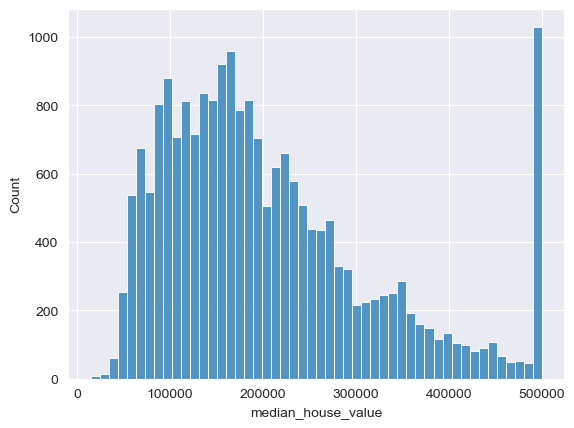

In [6]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"




data = fetch_data(url=url)

sns.histplot(data.median_house_value, bins=50)
plt.show()

# select 'latitude' and 'longitude' columns
data = data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']]


In [7]:
# check for missing values
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [8]:
data.population.median()

1166.0

In [9]:
# shuffle the dataset
data = data.sample(frac=1, random_state=42)

# # split the dataset into train, val and test sets
# n = len(data)
# n_val = int(0.2 * n)
# n_test = int(0.2 * n)
# n_train = n - n_val - n_test


# df_train = data.iloc[:n_train]
# df_val = data.iloc[n_train:n_train+n_val]
# df_test = data.iloc[n_train+n_val:]

# # reset the indices
# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)





In [10]:
train_set, test_set, val_set = train_test_val_split(data, val_split=0.2, test_split=0.2)

In [11]:
train_set.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0


In [12]:
def prepare_data(df: pd.DataFrame, impute_strategy: str) -> np.array:
    """
    Function to prepare data for training.

    Args:
        df (pd.DataFrame): dataframe to prepare
        base_cols (List[str]): list of columns to use as base feature set
        impute_strategy (str): strategy to use for imputation. Must be one of 'median', 'mean', or 'zero'

    Returns:
        array: array of features
    """
    y = np.log1p(df.median_house_value)
    df = df.drop('median_house_value', axis=1)
    df = impute_missing_values(df, impute_strategy)

    return df.values, y.values 

X_train, y_train = prepare_data(train_set, impute_strategy='mean')

In [13]:
w0, w, y_pred = train_linear_regression(X_train, y_train)